In [16]:
import datetime as dt
import pickle
import pandas as pd
import numpy as np
import os
import sys
sys.path.append(os.getcwd())
from hawkes import dataLoader, fit, inference, simulate

# Generate Fake Data

## Create Fake Params

In [2]:
mat = np.zeros((12,12))
for i in range(12):
    mat[i][i] = .66
for i in range(12):
    for j in range(12):
        if i == j: continue
        mat[i][j] = np.random.choice([1,-1])*mat[i][i]*np.exp(-.75*np.abs(j-i))

In [3]:
cols = ["lo_deep_Ask", "co_deep_Ask", "lo_top_Ask","co_top_Ask", "mo_Ask", "lo_inspread_Ask" ,
            "lo_inspread_Bid" , "mo_Bid", "co_top_Bid", "lo_top_Bid", "co_deep_Bid","lo_deep_Bid" ]

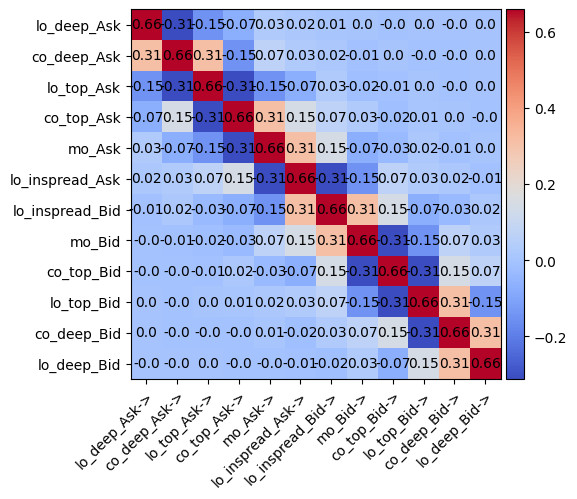

In [4]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(mat.transpose(), cmap='coolwarm')
fig.colorbar(im, cax=cax, orientation='vertical')
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(cols)), labels=[c +"->" for c in cols])
ax.set_yticks(np.arange(len(cols)), labels=cols)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(cols)):
    for j in range(len(cols)):
        text = ax.text(i,j, np.round(mat[i][j], decimals=2),
                               ha="center", va="center")
# fig.savefig("heatmap.png")
plt.show()


In [5]:
# norm should be less than 1
np.max(np.linalg.eig(mat)[0])

(0.9961648697231558+0j)

In [6]:
# create fake TOD params - 1.0 for now but can be changed to whatever you wish
faketod = {}
for k in cols:
    faketod[k] = {}
    for k1 in np.arange(13):
        faketod[k][k1] = 1.0
with open("fakeData_Params_sod_eod_dictTOD_constt", "wb") as f:
    pickle.dump(faketod, f)

In [8]:
# Create fake power law kernel params from the above norm matrix
paramsFake = {}
for i in range(12):
    paramsFake[cols[i]] = 0.1*np.random.choice([0.3,0.4,0.5,0.6,0.7])
    for j in range(12):
        maxTOD = np.max(list(faketod[cols[j]].values()))
        beta = np.random.choice([1.5,1.6,1.7,1.8,1.9])
        gamma = (1+np.random.rand())*5e3
        alpha = np.abs(mat[i][j])*gamma*(beta-1)/maxTOD
        paramsFake[cols[i]+"->"+cols[j]] = (np.sign(mat[i][j]), np.array([alpha, beta, gamma]))

In [9]:
mat = np.zeros((12,12))
for i in range(len(cols)):
    for j in range(len(cols)):
        kernelParams = paramsFake.get(cols[j]+"->"+cols[i], None)
        if kernelParams is None: continue
        mat[i][j] = kernelParams[0]*kernelParams[1][0]/((-1 + kernelParams[1][1])*kernelParams[1][2])

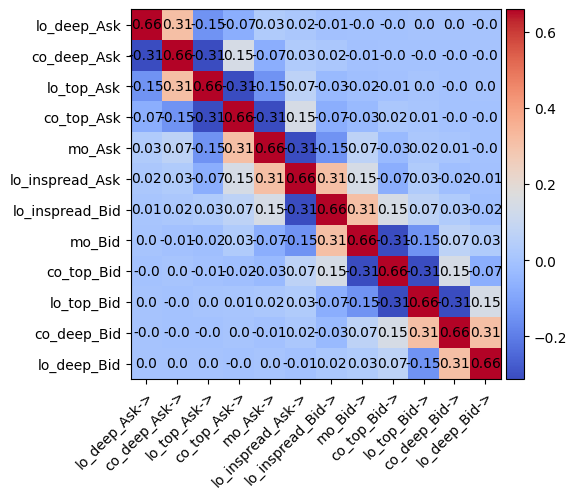

In [10]:
# norm matrix from this fake power law kernels - does it match the above figure? - YES.
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(mat.transpose(), cmap='coolwarm')
fig.colorbar(im, cax=cax, orientation='vertical')
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(cols)), labels=[c +"->" for c in cols])
ax.set_yticks(np.arange(len(cols)), labels=cols)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(cols)):
    for j in range(len(cols)):
        text = ax.text(i,j, np.round(mat[i][j], decimals=2),
                               ha="center", va="center")
# fig.savefig("heatmap.png")
plt.show()


In [11]:
with open("fake_ParamsInferredWCutoff_sod_eod_true", "wb") as f:
    pickle.dump(paramsFake, f)

## Simulate Fake LOB Data

In [17]:
os.mkdir("./simulated_data")

In [14]:
#### WARNING: THIS PIECE OF CODE TAKES A LONG TIME ####
for i in range(10):
    T, lob, lobL3=simulate.simulate(6.5*3600, "fake_ParamsInferredWCutoff_sod_eod_true", "fakeData_Params_sod_eod_dictTOD_constt", beta = 1., avgSpread = .01, spread0 = 5, price0 = 45)
    with open("./simulated_data/fake_simulated_sod_eod_"+ str(i) , "wb") as f:
        pickle.dump((T, lob, lobL3), f)

'D:\\Work\\PhD\\Expt 1\\lobSimulations'

In [ ]:
# save as 12D 
paths = [i for i in os.listdir(os.getcwd()+"/simulated_data") if ("fake_simulated" in i)]
for p in paths:
    resPath = p
    with open(resPath, 'rb') as f:
        results = pickle.load(f)
    
    ask_t = []
    bid_t = []
    ask_d = []
    bid_d= []
    event = []
    time = []
    for r, j in zip(results[1][1:], results[0][1:]):
        ask_t.append(r['Ask_touch'][0])
        bid_t.append(r['Bid_touch'][0])
        ask_d.append(r['Ask_deep'][0])
        bid_d.append(r['Bid_deep'][0])
        event.append(j[0])
        time.append(j[1])
    df = pd.DataFrame({"Time" : time, "event" : event, "Ask Price 1" : ask_t, "Bid Price 1": bid_t, "Ask Price 2": ask_d, "Bid Price 2" : bid_d})
    df['BidDiff'] = df['Bid Price 1'].diff()
    df['AskDiff'] = df['Ask Price 1'].diff()
    df['BidDiff2']= df['Bid Price 2'].diff()
    df['AskDiff2']= df['Ask Price 2'].diff()
    id = (resPath.split("/")[-1]).split("_")[-1]
    df["Date"] = id
    df.to_csv("./simulated_data/fake_" + id +"_12D.csv")

## Bin to custom bins

In [ ]:
#### WARNING: THIS PIECE OF CODE TAKES A LONG TIME ####
ric = "fake"
d = 0
l =  dataLoader.Loader(ric, d, d, dataPath = "./simulated_data/")
for d in range(100):
    df = pd.read_csv(l.dataPath+"fake_"+d+"_12D.csv")
    data = {str(i) : list(df.groupby('event')['Time'].apply(np.array)[cols].values)}
    cls = fit.ConditionalLeastSquaresLogLin(data, loader = l) 
    cls.runTransformDate()

# Fit Fake Data

## Hawkes Graph

In [ ]:
!git clone https://github.com/achab/nphc.git nphc2
# in line 1 of nphc2/nphc/cumulants.py, remove the autojit import and line 235 remove decorator

In [ ]:
import sys
import os
sys.path.append(os.getcwd()+"\\nphc2")
import matplotlib.pyplot as plt
from nphc.main import NPHC
import pandas as pd
import datetime as dt
import numpy as np

In [ ]:
big_data = []
cols = ["lo_deep_Ask", "co_deep_Ask", "lo_top_Ask","co_top_Ask", "mo_Ask", "lo_inspread_Ask" ,
            "lo_inspread_Bid" , "mo_Bid", "co_top_Bid", "lo_top_Bid", "co_deep_Bid","lo_deep_Bid" ]
for d in range(100): #pd.date_range(dt.date(2019,1,2), dt.date(2019,1,4)):
    
    df = pd.read_csv("./simulated_data/fake_"+str(d)+"_12D.csv")
    
    timestamps = list(df.groupby('event')['Time'].apply(np.array)[cols].values)
    big_data.append(timestamps)

In [ ]:
nphc = NPHC()
nphc.fit(big_data,half_width=1.,filtr="rectangular",method="parallel_by_day")
cumulants_list = [nphc.L, nphc.C, nphc.K_c]
from nphc.main import starting_point
start_point = starting_point(cumulants_list, random=True)
R_pred = nphc.solve(training_epochs=50000,display_step=500,learning_rate=1e-2,optimizer='adam')
d = len(nphc.L[0])
from scipy.linalg import inv
G_pred = np.eye(d) - inv(R_pred)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,10)
plt.rcParams['xtick.labelsize'] = 26
plt.rcParams['ytick.labelsize'] = 26
dimensions = cols 
sns_plot = sns.heatmap(G_pred.T,cmap="RdBu_r",xticklabels=dimensions,yticklabels=dimensions)

In [ ]:
boundsDict = {}
for i in range(12):
    for j in range(12):
        boundsDict[cols[i]+"->"+cols[j]] = np.sign(G_pred[i][j])
import pickle
with open("fake_2019-01-02_2019-03-31_graphDict", "wb") as f:
    pickle.dump(boundsDict, f)

## 12D Hawkes Non-Parametric Fit:

In [ ]:
ric = "fake"
dictIp = {}
d = 0
l =  dataLoader.Loader(ric, d, d, dataPath = "./simulated_data/")
for d in range(100):
    dictIp[d] = []
cls = fit.ConditionalLeastSquaresLogLin(dictIp, loader = l, solver="osqp", path_dictTOD = "./fakeData_Params_sod_eod_dictTOD_constt")
thetas = cls.fitConditionalInSpread(spreadBeta = 1., avgSpread = 1.)
with open(l.dataPath + ric + "_Params_2019-01-02_2019-03-31_CLSLogLin_19" , "wb") as f:
    pickle.dump(thetas, f)

## Infer power law params:

In [ ]:
a, b = inference.run(dt.date(2019,1,2), dt.date(2019,3,31), ric = "fake" , avgSpread = 0.01, spreadBeta=1. , suffix = "_CLSLogLin_19")

# Simulate LOB from Fitted Fake Params

In [ ]:
#### WARNING: THIS PIECE OF CODE TAKES A LONG TIME ####
for i in range(10):
    T, lob, lobL3=simulate.simulate(6.5*3600, "fake_ParamsInferredWCutoff_2019-01-02_2019-01-31_CLSLogLin_19", "fakeData_Params_sod_eod_dictTOD_constt", beta = 1., avgSpread = 0.01, spread0 = 5, price0 = 45)
    with open("./simulated_data/fake_simulated_CLSLogLinFit_sod_eod_"+ str(i) , "wb") as f:
        pickle.dump((T, lob, lobL3), f)